<a href="https://colab.research.google.com/github/limestonestreams/thesis/blob/master/BERT_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To wrap output text, applies to every cell. (from https://stackoverflow.com/questions/58890109/line-wrapping-in-collaboratory-google-results)

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

Mounting google drive:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wHPvbhif1y1LKlNh5at2oP7ltCU69_X_etQMgmeO3t_n5Z8twvmoh4
Mounted at /content/gdrive


Importing the UNSC text data and the UCDP event dataset:

In [ ]:
import feather
import pandas as pd
import numpy as np

docs = feather.read_dataframe('/content/gdrive/My Drive/Colab files/speeches.feather')

events = pd.read_csv('/content/gdrive/My Drive/Colab files/ged201.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# UNSC speeches

#keeping only relevant columns
docs = docs[['topic', 'date', 'text']]
#adding key column to merge text on
docs['date'] = docs['date'].astype(str)
docs['topic'] = docs['topic'].astype(str)
docs['key'] = docs['date'] + docs['topic']
#merging on key column so that each text cell contains all speech on that topic that day
docs = docs.groupby('key').agg({'date': 'first', 'topic': 'first', 'text': r'\n\n'.join}).reset_index(drop = True)
#dropping key column
docs = docs[['date', 'topic', 'text']]
#changing dtype to datetime
docs['date'] = pd.to_datetime(docs['date'])
docs = docs.sort_values(by = 'date').reset_index(drop = True)

# UCDP events dataset

events['date_start'] = pd.to_datetime(events['date_start'])
#events = events[['active_year', 'type_of_violence', 'country', 'date_start', 'best']]
events = events[['country', 'date_start']]
#creating new column which marks that there is an event on that day
events['event'] = 1

Selecting the conflicts that appear in both datasets:

In [ ]:
# Changing labels in my UNSC dataset to match the ones in the UCDP dataset:
docs['topic'] = docs['topic'].astype(str)
docs.loc[docs['topic'] == 'Bougainville', 'topic'] = 'Papua New Guinea'
docs.loc[docs['topic'] == 'Democratic Republic Of The Congo', 'topic'] = 'DR Congo (Zaire)'
docs.loc[docs['topic'] == 'Bosnia And Herzegovina', 'topic'] = 'Bosnia-Herzegovina'
docs.loc[docs['topic'] == "Code D'Ivoire", 'topic'] = 'Ivory Coast'
docs.loc[docs['topic'] == "The Former Yugoslav Republic Of Macedonia", 'topic'] = 'Macedonia, FYR'
docs.loc[docs['topic'] == "Myanmar", 'topic'] = 'Myanmar (Burma)'
docs.loc[docs['topic'] == "Yugoslavia", 'topic'] = 'Serbia (Yugoslavia)'
docs.loc[docs['topic'] == "Zimbabwe", 'topic'] = 'Zimbabwe (Rhodesia)'
docs.loc[docs['topic'] == "Venezuela (Bolivarian Republic Of)", 'topic'] = 'Venezuela'

ucdp_countries = events['country'].value_counts().index.values.astype(str)
print(sorted(ucdp_countries))

unsc_topics = docs['topic'].value_counts().index.values.astype(str)
print(sorted(unsc_topics))

conflicts = set(ucdp_countries) & set(unsc_topics)
print(sorted(conflicts))

['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia', 'Australia', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belgium', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia-Herzegovina', 'Botswana', 'Brazil', 'Burkina Faso', 'Burundi', 'Cambodia (Kampuchea)', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'China', 'Colombia', 'Comoros', 'Congo', 'Croatia', 'DR Congo (Zaire)', 'Djibouti', 'Ecuador', 'Egypt', 'El Salvador', 'Eritrea', 'Ethiopia', 'France', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'India', 'Indonesia', 'Iran', 'Iraq', 'Israel', 'Italy', 'Ivory Coast', 'Jamaica', 'Jordan', 'Kenya', 'Kingdom of eSwatini (Swaziland)', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Macedonia, FYR', 'Madagascar (Malagasy)', 'Malaysia', 'Mali', 'Malta', 'Mauritania', 'Mexico', 'Moldova', 'Morocco', 'Mozambique', 'Myanmar (Burma)', 'Namibia', 'Nepal', 'Netherlands', 'Nicaragua', 'Niger',

Subsetting both datasets so that they contain only the matched conflicts in the 'conflicts' list:

In [ ]:
docs = docs[docs['topic'].isin(conflicts)]

events = events[events['country'].isin(conflicts)]

Turning text into lowercase.

In [ ]:
#This line also removes non-alphanumeric characters, but BERT doesn't actually need that
#docs['text'] = docs['text'].replace('[^a-zA-Z0-9 ]', ' ', regex = True).str.lower()

docs['text'] = docs['text'].str.lower()

Counting the number of words per day:

In [ ]:
docs['word_count'] = docs['text'].str.split().str.len()

Adding column for whether that date had a meeting or not:

In [ ]:
docs['meeting'] = np.where(docs['word_count'] > 0, 1, 0)

Splitting both datasets into country-specific ones and merging based on dates into one dictionary:

In [ ]:
from datetime import timedelta

#initializing dictionaries
docs_dict = {}
events_dict = {}
data_dict = {}

for i in conflicts:
    #creating docs specific to country
    docs_dict[str(i).lower()] = docs[docs['topic'] == str(i)]
    #creating events specific to country
    events_dict[str(i).lower()] = events[events['country'] == str(i)]
    #checking their time range
    earliest_date = min(docs_dict[str(i).lower()]['date'])
    latest_date = max(docs_dict[str(i).lower()]['date']) + timedelta(days = 7)
    #initializing timerange to merge on
    time_range = pd.date_range(start = earliest_date, end = latest_date)
    time_range = pd.DataFrame(time_range)
    time_range.columns = ['date']
    #merging time_range with docs
    data_dict[str(i).lower()] = pd.merge(time_range, 
                                         docs_dict[str(i).lower()], 
                                         on = 'date', 
                                         how = 'left').sort_values('date').reset_index(drop = True)  
    #merging time_range with events 
    data_dict[str(i).lower()] = pd.merge(data_dict[str(i).lower()], 
                                         events_dict[str(i).lower()], 
                                         left_on = 'date', 
                                         right_on = 'date_start', 
                                         how = 'left').sort_values('date').reset_index(drop = True)
    #removing superfluous columns
    del data_dict[str(i).lower()]['date_start']
    del data_dict[str(i).lower()]['country']  
    #filling event column with 0 for dates when no event happened                                  
    data_dict[str(i).lower()]['event'] = data_dict[str(i).lower()]['event'].fillna(0)                                       

In [ ]:
data_dict['dr congo (zaire)']

,date,topic,text,word_count,meeting,event
0,1996-11-15,DR Congo (Zaire),"allow me, at the outset,\nto congratulate you ...",16209.0,1.0,1.0
1,1996-11-15,DR Congo (Zaire),"allow me, at the outset,\nto congratulate you ...",16209.0,1.0,1.0
2,1996-11-16,NaN,NaN,NaN,NaN,0.0
3,1996-11-17,NaN,NaN,NaN,NaN,1.0
4,1996-11-18,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...
10079,2019-12-22,NaN,NaN,NaN,NaN,1.0
10080,2019-12-23,NaN,NaN,NaN,NaN,1.0
10081,2019-12-24,NaN,NaN,NaN,NaN,0.0
10082,2019-12-25,NaN,NaN,NaN,NaN,0.0


Checking by plotting:

(array([727929., 728659., 729390., 730120., 730851., 731581., 732312.,
        733042., 733773.]), <a list of 9 Text major ticklabel objects>)

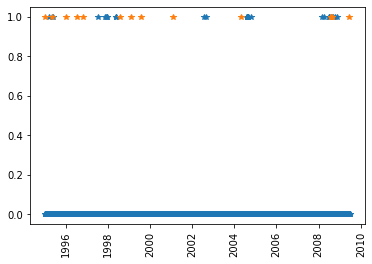

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(data_dict['georgia']['date'], data_dict['georgia']['event'], '*')
plt.plot(data_dict['georgia']['date'], data_dict['georgia']['meeting'], '*')
plt.xticks(rotation = 'vertical')

Saving this:

In [ ]:
# package for saving panda dictionaries
import pickle

with open('/content/gdrive/My Drive/Colab files/all_datasets', 'wb') as f:
   pickle.dump(data_dict, f)

In [ ]:
# checking that it works
with open('/content/gdrive/My Drive/Colab files/all_datasets', 'rb') as f:
   d_check = pickle.load(f)

In [ ]:
d_check

{'afghanistan':             date        topic  ... meeting  event
 0     1996-04-09  Afghanistan  ...     1.0    1.0
 1     1996-04-10          NaN  ...     NaN    1.0
 2     1996-04-11          NaN  ...     NaN    0.0
 3     1996-04-12          NaN  ...     NaN    1.0
 4     1996-04-12          NaN  ...     NaN    1.0
 ...          ...          ...  ...     ...    ...
 34973 2019-12-23          NaN  ...     NaN    1.0
 34974 2019-12-23          NaN  ...     NaN    1.0
 34975 2019-12-23          NaN  ...     NaN    1.0
 34976 2019-12-23          NaN  ...     NaN    1.0
 34977 2019-12-23          NaN  ...     NaN    1.0
 
 [34978 rows x 6 columns],
 'albania':           date    topic  ... meeting  event
 0   1997-03-28  Albania  ...     1.0    0.0
 1   1997-03-29      NaN  ...     NaN    0.0
 2   1997-03-30      NaN  ...     NaN    0.0
 3   1997-03-31      NaN  ...     NaN    0.0
 4   1997-04-01      NaN  ...     NaN    0.0
 ..         ...      ...  ...     ...    ...
 142 1997-08-17   